In [152]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt     
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

from scipy.stats import norm
from scipy.integrate import quad

import matplotlib.pyplot as plt



In [153]:
df = pd.read_csv('Price_MGP.csv')
df = df[[ "date", "Day", "month", "year", "Hour","CNOR", "CSUD", "NORD", "SARD", "SICI", "SUD"]]
df["date"]=df["date"].astype("datetime64[ns]")
df_sorted_hour = df[df["Hour"] == 11]
df_sorted_hour = df_sorted_hour.sort_values("date")
df_sorted_hour.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,3287,2015-06-30 22:09:09.802251264,2011-01-01 00:00:00,2013-04-01 12:00:00,2015-07-02 00:00:00,2017-09-30 12:00:00,2019-12-31 00:00:00,NaN
Day,3287.0,15.728628,1.0,8.0,16.0,23.0,31.0,8.801004
month,3287.0,6.523274,1.0,4.0,7.0,10.0,12.0,3.449133
year,3287.0,2014.999392,2011.0,2013.0,2015.0,2017.0,2019.0,2.582185
Hour,3287.0,11.0,11.0,11.0,11.0,11.0,11.0,0.0
CNOR,3287.0,60.93888,0.0,47.82,59.89,72.33,217.0,19.558867
CSUD,3287.0,58.930821,0.0,46.16,57.43,70.0,217.0,19.099502
NORD,3287.0,62.593696,2.248008,49.725,61.26,73.965,217.0,19.049166
SARD,3287.0,60.507286,0.0,46.025,57.33552,70.355,300.0,24.769971
SICI,3287.0,75.448709,0.0,51.83,64.93,98.155,190.0,33.249806


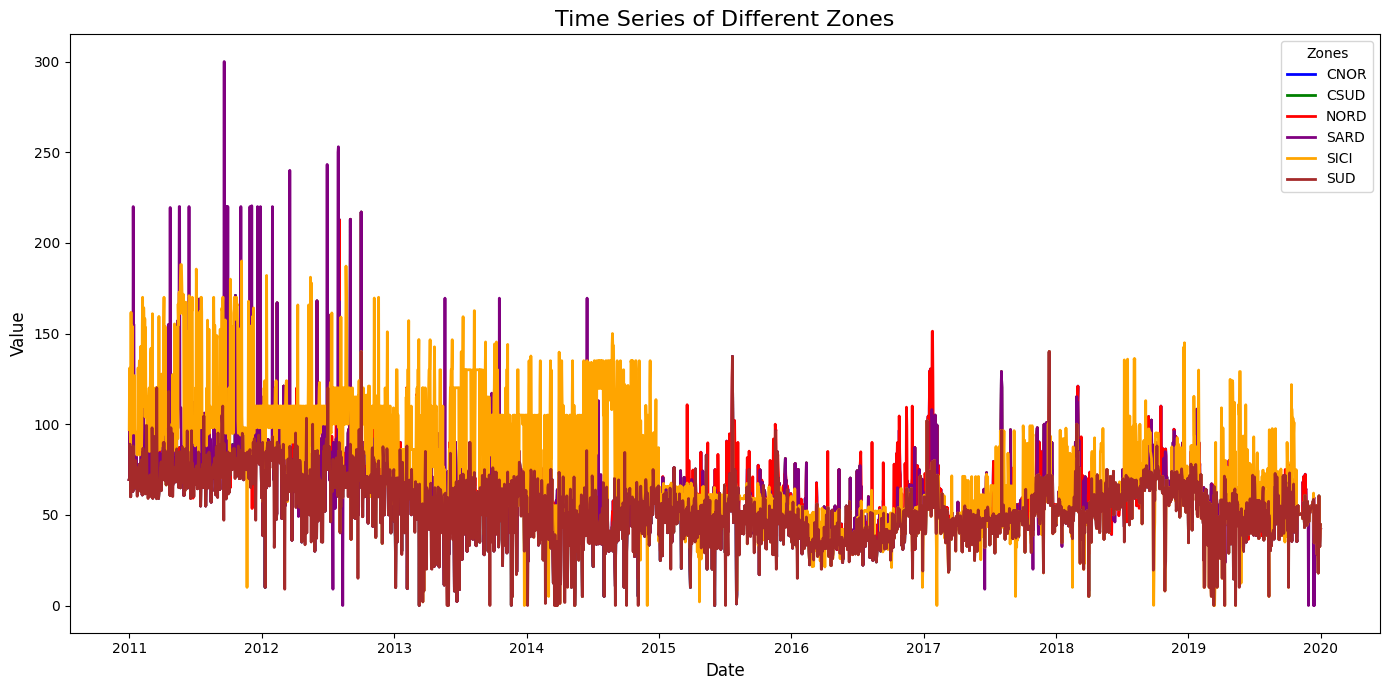

In [154]:

# Plot the time series
plt.figure(figsize=(14, 7))

plt.plot(df_sorted_hour["date"], df_sorted_hour["CNOR"], color='blue', linewidth=2, label='CNOR')
plt.plot(df_sorted_hour["date"], df_sorted_hour["CSUD"], color='green', linewidth=2, label='CSUD')
plt.plot(df_sorted_hour["date"], df_sorted_hour["NORD"], color='red', linewidth=2, label='NORD')
plt.plot(df_sorted_hour["date"], df_sorted_hour["SARD"], color='purple', linewidth=2, label='SARD')
plt.plot(df_sorted_hour["date"], df_sorted_hour["SICI"], color='orange', linewidth=2, label='SICI')
plt.plot(df_sorted_hour["date"], df_sorted_hour["SUD"],  color='brown', linewidth=2, label='SUD')

# Format x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add titles and labels
plt.title("Time Series of Different Zones", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)

plt.legend(title="Zones", fontsize=10)
plt.tight_layout()


In [155]:
#genereate log yelds
def log_yield(df, col):
    #if np.log(df[col]) =0 then np.log(df[col]) =1
    df[col] = df[col].replace(0, 1)
    return (np.log(df[col]) - np.log(df[col].shift(1)))*100

In [156]:
R_CNOR = log_yield(df_sorted_hour, "CNOR")
R_CSUD = log_yield(df_sorted_hour, "CSUD")
R_NORD = log_yield(df_sorted_hour, "NORD")      
R_SARD = log_yield(df_sorted_hour, "SARD")
R_SICI = log_yield(df_sorted_hour, "SICI")
R_SUD = log_yield(df_sorted_hour, "SUD")
df_sorted_hour["R_CNOR"] = R_CNOR   
df_sorted_hour["R_CSUD"] = R_CSUD
df_sorted_hour["R_NORD"] = R_NORD
df_sorted_hour["R_SARD"] = R_SARD
df_sorted_hour["R_SICI"] = R_SICI
df_sorted_hour["R_SUD"] = R_SUD
df_sorted_hour.dropna(inplace=True)
df_sorted_hour.describe().transpose()


,count,mean,min,25%,50%,75%,max,std
date,3286,2015-07-01 10:08:41.485088256,2011-01-02 00:00:00,2013-04-02 06:00:00,2015-07-02 12:00:00,2017-09-30 18:00:00,2019-12-31 00:00:00,NaN
Day,3286.0,15.73311,1.0,8.0,16.0,23.0,31.0,8.798591
month,3286.0,6.524954,1.0,4.0,7.0,10.0,12.0,3.448312
year,3286.0,2015.000609,2011.0,2013.0,2015.0,2017.0,2019.0,2.581635
Hour,3286.0,11.0,11.0,11.0,11.0,11.0,11.0,0.0
CNOR,3286.0,60.936877,0.9,47.82,59.89,72.33,217.0,19.55939
CSUD,3286.0,58.928511,0.1,46.155,57.405,70.0,217.0,19.098721
NORD,3286.0,62.591588,2.248008,49.7225,61.255,73.9725,217.0,19.051681
SARD,3286.0,60.506673,0.1,46.0175,57.32776,70.3575,300.0,24.76808
SICI,3286.0,75.445498,0.1,51.83,64.93,98.1575,190.0,33.245192


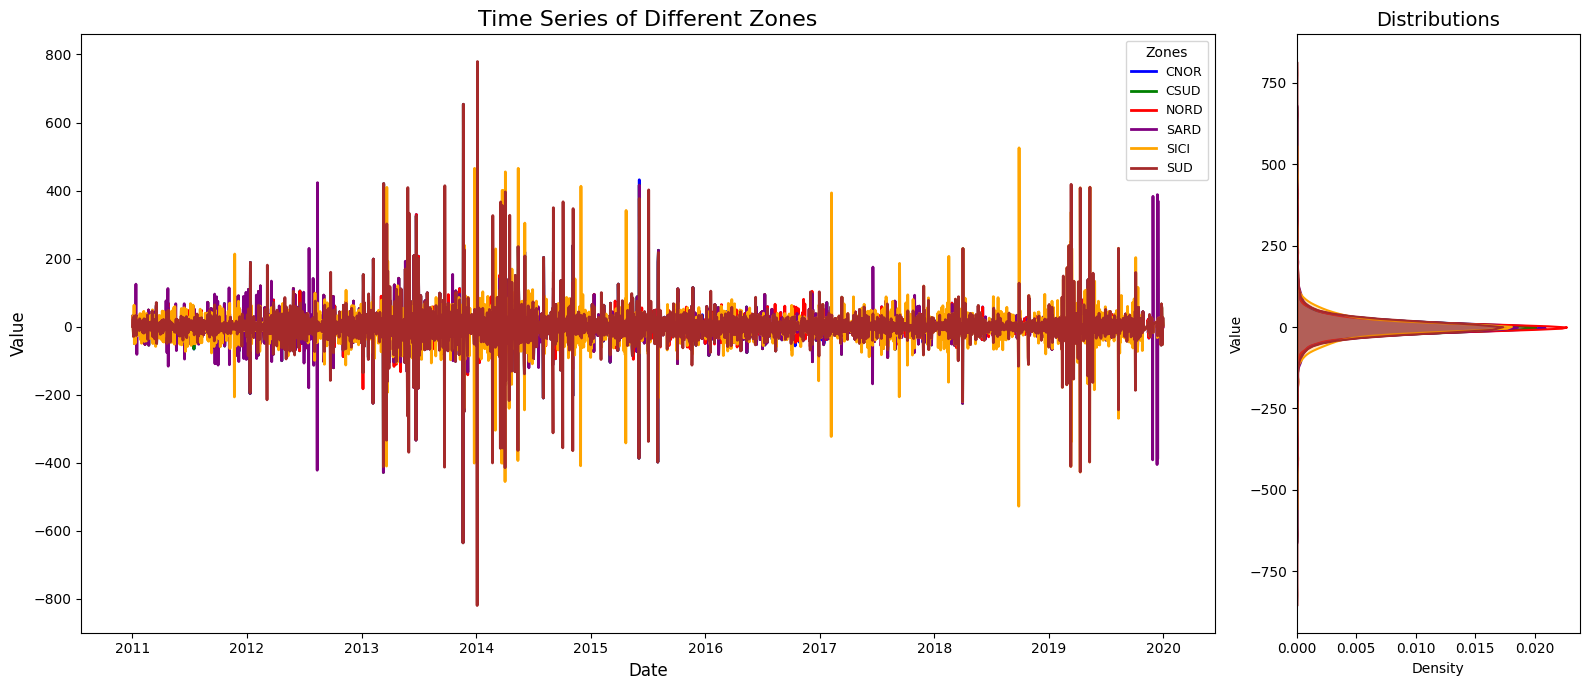

In [157]:


# Create a figure with two subplots: time series (wide) and KDEs (narrow)
fig = plt.figure(figsize=(16, 7))
gs = GridSpec(1, 2, width_ratios=[4, 1])  # 4:1 ratio

# === Left plot: Time series ===
ax0 = fig.add_subplot(gs[0])

# Plot each time series
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_CNOR"], color='blue', linewidth=2, label='CNOR')
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_CSUD"], color='green', linewidth=2, label='CSUD')
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_NORD"], color='red', linewidth=2, label='NORD')
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_SARD"], color='purple', linewidth=2, label='SARD')
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_SICI"], color='orange', linewidth=2, label='SICI')
ax0.plot(df_sorted_hour["date"], df_sorted_hour["R_SUD"], color='brown', linewidth=2, label='SUD')

# Format x-axis to show only years
ax0.xaxis.set_major_locator(mdates.YearLocator())
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Labels
ax0.set_title("Time Series of Different Zones", fontsize=16)
ax0.set_xlabel("Date", fontsize=12)
ax0.set_ylabel("Value", fontsize=12)
ax0.legend(title="Zones", fontsize=9)

# === Right plot: KDEs ===
ax1 = fig.add_subplot(gs[1])

# Plot KDEs vertically
sns.kdeplot(y=df_sorted_hour["R_CNOR"].dropna(), ax=ax1, color='blue', label='CNOR', fill=True, linewidth=1.5)
sns.kdeplot(y=df_sorted_hour["R_CSUD"].dropna(), ax=ax1, color='green', label='CSUD', fill=True, linewidth=1.5)
sns.kdeplot(y=df_sorted_hour["R_NORD"].dropna(), ax=ax1, color='red', label='NORD', fill=True, linewidth=1.5)
sns.kdeplot(y=df_sorted_hour["R_SARD"].dropna(), ax=ax1, color='purple', label='SARD', fill=True, linewidth=1.5)
sns.kdeplot(y=df_sorted_hour["R_SICI"].dropna(), ax=ax1, color='orange', label='SICI', fill=True, linewidth=1.5)
sns.kdeplot(y=df_sorted_hour["R_SUD"].dropna(), ax=ax1, color='brown', label='SUD', fill=True, linewidth=1.5)

ax1.set_xlabel("Density")
ax1.set_ylabel("Value")
ax1.set_title("Distributions", fontsize=14)
#ax1.get_legend().remove()

# Adjust layout
plt.tight_layout()
plt.show()


In [158]:
import numpy as np

def gcvar(losses,alpha=0.95, g=lambda u: u):
    """
    Compute the Generalized Conditional Value at Risk (GCVaR).
    
    Parameters:
        losses (array-like): Vector of losses (higher = worse).
        alpha (float): Confidence level (e.g., 0.95).
        g (function): Distortion function g(u), where u in [0, 1].
        
    Returns:
        GCVaR (float): Generalized Conditional Value at Risk
    """
    losses = np.sort(losses)
    n = len(losses)
    u_vals = np.arange(1, n + 1) / n  # Empirical probabilities
    
    # Compute VaR at different u levels
    VaR_u = np.quantile(losses, u_vals, method='linear')  # type 7 equivalent
    # Distortion function for standard CVaR
    # Numerical derivative of g(u)
    g_vals = g(u_vals)
    g_derivative = np.diff(g_vals) / np.diff(u_vals)
    g_midpoints = (g_derivative[1:] + g_derivative[:-1]) / 2

    # Approximate the integral using trapezoidal rule over (alpha, 1]
    valid_idx = u_vals[1:] > alpha
    integral_approx = np.sum(g_midpoints[valid_idx[1:]] * VaR_u[1:][valid_idx] * np.diff(u_vals)[valid_idx])

    GCVaR = integral_approx / (1 - alpha)
    return GCVaR


In [159]:
np.random.seed(123)
losses = df_sorted_hour["R_CNOR"]  # Example losses (absolute values of returns)
# Calcolo GCVaR
result = gcvar(losses,alpha = 0.99)
print("GCVaR (standard CVaR case):", result)

GCVaR (standard CVaR case): 170.4015602018114


In [160]:
# Extreme Downside Correlation (EDC)
def EDC_range(start_year, end_year, df, R1, R2,alpha=0.975, 
              start_month=1, start_day=1, 
              end_month=12, end_day=31):
    """
    Calculates the Extreme Downside Correlation (EDC) between two time series
    for a specified date range (by year, month, or day).

    Parameters:
    ---------------
    start_year (int): The starting year for the calculation.
    end_year (int): The ending year for the calculation (inclusive).
    df (DataFrame): The dataframe containing the time series data.
    R1 (str): The column name for the first time series.
    R2 (str): The column name for the second time series.
    start_month (int, optional): The starting month (default is 1 for January).
    start_day (int, optional): The starting day (default is 1).
    end_month (int, optional): The ending month (default is 12 for December).
    end_day (int, optional): The ending day (default is 31).
    Returns:
    --------
    float: The Extreme Downside Correlation value between R1 and R2 over the 
           specified time period. Returns np.nan if the denominator is zero.
    """
    
    df = df.copy()
    df = df.dropna()
    df["date"] = pd.to_datetime(df["date"])

    # Costruisci le date precise
    start_date = pd.Timestamp(start_year, start_month, start_day)
    end_date = pd.Timestamp(end_year, end_month, end_day)

    # Filtra per l'intervallo temporale
    df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

    #extract the values of the series 
    R1_vals = df[R1].values
    R2_vals = df[R2].values

    
    # Calcola media, numeratore, denominatore
    R1_mean = np.mean(R1_vals)
    R2_mean = np.mean(R2_vals)
    
    # fixed cvar for the considered time period
    Cvar_R1_filtr = gcvar(R1_vals,alpha = alpha)
    Cvar_R2_filtr = gcvar(R2_vals,alpha = alpha)
    
    #list comperension to calculate cvar for each zone in the time 
    R1_Cvals = [R1_vals[n] if n < 2 else gcvar(R1_vals[:n]) for n in range(len(R1_vals))]
    R2_Cvals = [R2_vals[n] if n < 2 else gcvar(R2_vals[:n]) for n in range(len(R2_vals))]
    
    bol_R1 = np.where(R1_Cvals > Cvar_R1_filtr, 1, 0)
    bol_R2 = np.where(R2_Cvals > Cvar_R2_filtr, 1, 0)
    
    numerator = np.sum((R1_vals - R1_mean) * bol_R1 * (R2_vals - R2_mean) * bol_R2)
    denominator = np.sqrt(np.sum(((R1_vals - R1_mean) * bol_R1)**2)) * np.sqrt(np.sum(((R2_vals - R2_mean) * bol_R2)**2))
 
    return numerator/ denominator 

In [161]:
EDC_range(2015, 2020, df_sorted_hour, "R_CNOR", "R_SUD")

0.30448857771330246

In [162]:
zone_list = ["R_CNOR", "R_CSUD", "R_NORD", "R_SARD", "R_SICI", "R_SUD"]
EDC_matrix = pd.DataFrame(index=zone_list, columns=zone_list)
ds = 2011
de = 2012
for i in range(len(zone_list)):
    for j in range(len(zone_list)):
        if i != j:
            EDC_matrix.iloc[i, j] = EDC_range(ds,de, df_sorted_hour, zone_list[i], zone_list[j])
        else:
            EDC_matrix.iloc[i, j] = 0


In [163]:
EDC_matrix

,R_CNOR,R_CSUD,R_NORD,R_SARD,R_SICI,R_SUD
R_CNOR,0,0.993029,0.972025,0.163249,0.356233,0.417032
R_CSUD,0.993029,0,0.980071,0.263346,0.327896,0.414125
R_NORD,0.972025,0.980071,0,0.298574,0.414597,0.476608
R_SARD,0.163249,0.263346,0.298574,0,-0.027751,0.198558
R_SICI,0.356233,0.327896,0.414597,-0.027751,0,0.599425
R_SUD,0.417032,0.414125,0.476608,0.198558,0.599425,0


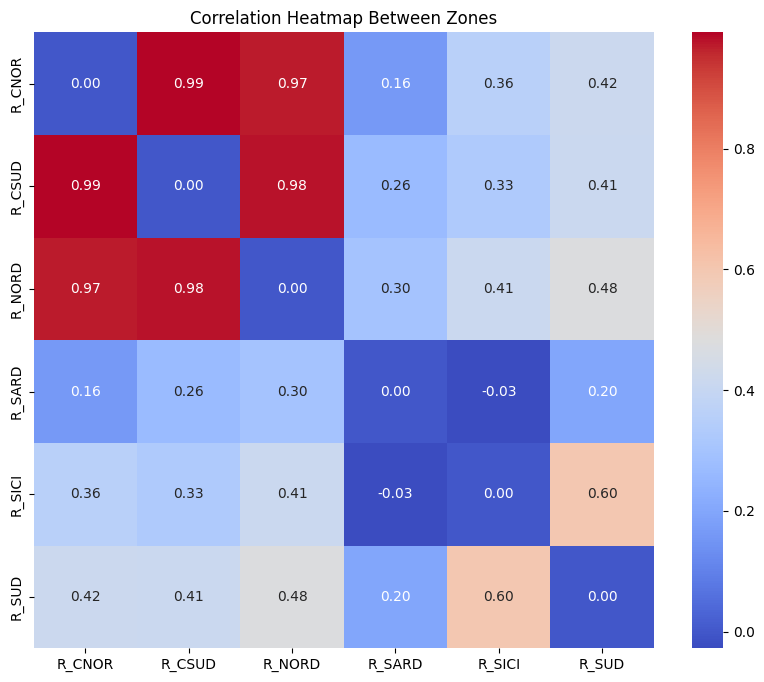

In [164]:
# Convert EDC_matrix to numeric type
EDC_matrix = EDC_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(EDC_matrix, annot=True, fmt=".2f", cmap="coolwarm")  # Added annotations and colormap

plt.title("Correlation Heatmap Between Zones")
plt.show()

In [ ]:
#Rolling window EDC
# define network density 
def network_density(EDC_matrix):
    """
    Calculate the network density of a correlation matrix.
    
    Parameters:
    ---------------
    EDC_matrix (DataFrame): The correlation matrix.
    
    Returns:
    --------
    float: The network density.
    """
    n = len(EDC_matrix)
    num_edges = np.sum(np.abs(EDC_matrix.values))  # Count edges with absolute value > 0.5
    return num_edges / (n * (n - 1))  # Maximum number of edges in a complete graph


In [ ]:
#rolling window of 250 days
def rolling_window_EDC(df, R1, R2, window_size=250, alpha=0.975):
    """
    Calculate the rolling Extreme Downside Correlation (EDC) between two time series.
    
    Parameters:
    ---------------
    df (DataFrame): The dataframe containing the time series data.
    R1 (str): The column name for the first time series.
    R2 (str): The column name for the second time series.
    window_size (int): The size of the rolling window (default is 250).
    alpha (float): Confidence level for CVaR calculation (default is 0.975).
    
    Returns:
    --------
    list: A list of EDC values for each rolling window.
    """
    
    df = df.copy()
    df = df.dropna()
    df["date"] = pd.to_datetime(df["date"])
    
    edc_values = []
    
    for i in range(len(df) - window_size + 1):
        window_df = df.iloc[i:i + window_size]
        edc_value = EDC_range(window_df["date"].min().year, window_df["date"].max().year, 
                              window_df, R1, R2, alpha=alpha)
        edc_values.append(edc_value)
        
    return edc_values